### Importar bibliotecas

In [38]:
# Conexão com BigQuery
from google.cloud import bigquery
from google.oauth2 import service_account
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import keras_tuner as kt
import matplotlib.pyplot as plt
import math
import calendar
from sklearn.metrics import mean_squared_error
from sklearn.metrics import average_precision_score
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from matplotlib.pylab import rcParams
from scikeras.wrappers import KerasRegressor
from keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint, uniform
import keras_tuner
from keras.layers import LSTM, Dropout, Dense
from scipy.stats import randint, uniform
from sklearn.preprocessing import MinMaxScaler

### Criar conexão com os dados no GCP

In [5]:
# Realizar conexão com o GCP
credentials = service_account.Credentials.from_service_account_file("../keys/ml-na-saude-ed1fc3c1a83e.json")
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

#### Criar dataframe com os dados já tratados e selecionados

In [6]:
# Os dados de mortalidade já foram tratados na ETL para calcular o YLL por cada óbito
# Aqui esta importação já está trazendo a taxa média do YLL dos municípios de médio porte por quedrimestre
consulta_sql = """
select
  a.quadrimestre,
  avg(a.taxa_yll) as taxa_media_yll
from (
with yll_quadrimestral as (
	select
		case
			when extract(month from y.dt_obito) between 1 and 4 then date(extract(year from y.dt_obito), 4, 30)
			when extract(month from y.dt_obito) between 5 and 8 then date(extract(year from y.dt_obito), 8, 31)
			when extract(month from y.dt_obito) between 9 and 12 then date(extract(year from y.dt_obito), 12, 31)
			end as quadrimestre,
		m.nm_municipio,
		p.populacao,
		sum(y.yll) as soma_yll
	from `ml-na-saude.yll_por_obito.yll` y
	join `ml-na-saude.yll_por_obito.populacao` p on y.cd_mun_res = p.cd_municipio and y.ano_obito = p.ano
	join `ml-na-saude.yll_por_obito.municipio` m on p.cd_municipio = m.cd_municipio
	where p.porte = 'Médio Porte'
    group by 1,2,3
)
select
	quadrimestre,
	nm_municipio,
  soma_yll,
  populacao,
  soma_yll / populacao * 1000 as taxa_yll
from yll_quadrimestral
group by 1,2,3,4
) a
group by 1
order by 1
"""

In [7]:
# Ignorar avisos e gerar dataframe
warnings.simplefilter("ignore")
df = client.query(consulta_sql).to_dataframe()

In [8]:
df.head()

,quadrimestre,taxa_media_yll
0,2010-04-30,6.427726
1,2010-08-31,6.767661
2,2010-12-31,6.111099
3,2011-04-30,6.550037
4,2011-08-31,6.878076


In [9]:
df.dtypes

quadrimestre       dbdate
taxa_media_yll    float64
dtype: object

### Cópia do DataFrame para manipulação e criação dos modelos

In [10]:
# Copiar dataframe para manipular dados
time_series = df.copy()

In [11]:
# Transformando o quadrimestre em data
time_series['quadrimestre'] = pd.to_datetime(time_series['quadrimestre'])

In [12]:
time_series.dtypes

quadrimestre      datetime64[ns]
taxa_media_yll           float64
dtype: object

In [13]:
# Setando o quadrimestre como índice da tabela
time_series = time_series.set_index('quadrimestre')

In [14]:
time_series

,taxa_media_yll
quadrimestre,
2010-04-30,6.427726
2010-08-31,6.767661
2010-12-31,6.111099
2011-04-30,6.550037
2011-08-31,6.878076
2011-12-31,5.804813
2012-04-30,6.280719
2012-08-31,6.739170
2012-12-31,6.049970


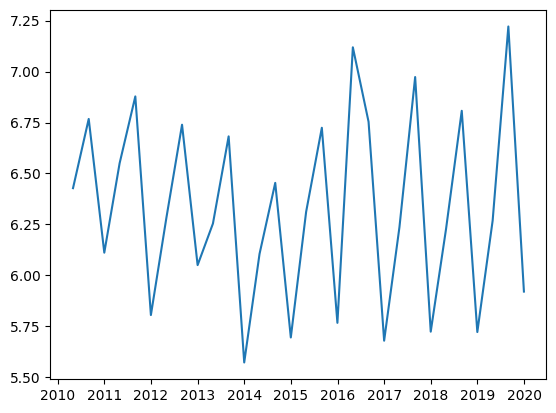

In [15]:
plt.plot(time_series)

### Metodos Para Calcular o Theils U Coefficient

In [16]:
#Metodos Para Calcular o Theils U Coefficient
def theil_u2(y_true, y_pred):
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    
    # Tamanho da amostra
    N = len(y_true)
    
    # Deslocamento de um elemento para cálculo do numerador e denominador
    y_true_prev = y_true[:-1]
    y_true_next = y_true[1:]
    y_pred_prev = y_pred[:-1]
    y_pred_next = y_pred[1:]
    
    # Numerador
    numerator = np.sqrt(np.mean(np.square((y_pred_next - y_pred_prev) / y_true_prev)))
    
    # Denominador
    denominator = np.sqrt(np.mean(np.square((y_true_next - y_true_prev) / y_true_prev)))
    
    # Cálculo do Theil U2
    theilU2 = numerator / denominator

    return theilU2

### Modelo

In [17]:
train_data= time_series.values

#Normaliza os Dados
normalizer = MinMaxScaler(feature_range=(0,1))
train_data = normalizer.fit_transform(train_data)

#Cria os Arrays No Formato Certo
x = []
y = []
for i in range(3, len(train_data)):
  x.append(train_data[i-3:i, 0])
  y.append(train_data[i,0])
x, y = np.array(x), np.array(y)
x = np.reshape(x, (x.shape[0], x.shape[1],1))

#Converte os Dados Para Float
x = np.asarray(x).astype('float32')
y = np.asarray(y).astype('float32')

len(x)

27

In [18]:
x

array([[[0.51879036],
        [0.7248761 ],
        [0.32683465]],

       [[0.7248761 ],
        [0.32683465],
        [0.59294134]],

       [[0.32683465],
        [0.59294134],
        [0.79181546]],

       [[0.59294134],
        [0.79181546],
        [0.14114882]],

       [[0.79181546],
        [0.14114882],
        [0.42966717]],

       [[0.14114882],
        [0.42966717],
        [0.7076034 ]],

       [[0.42966717],
        [0.7076034 ],
        [0.2897751 ]],

       [[0.7076034 ],
        [0.2897751 ],
        [0.41344082]],

       [[0.2897751 ],
        [0.41344082],
        [0.6729139 ]],

       [[0.41344082],
        [0.6729139 ],
        [0.        ]],

       [[0.6729139 ],
        [0.        ],
        [0.3231139 ]],

       [[0.        ],
        [0.3231139 ],
        [0.53448397]],

       [[0.3231139 ],
        [0.53448397],
        [0.07443231]],

       [[0.53448397],
        [0.07443231],
        [0.4483406 ]],

       [[0.07443231],
        [0.4483406 ],
    

In [19]:
x_train, y_train = x[:24], y[:24]
x_test, y_test = x[24:], y[24:]

In [20]:
#Cria o Modelo De Rede Neural
dropout_val = 0.2
regressor = Sequential()
regressor.add(LSTM(units = 800, return_sequences = True, input_shape=(x_train.shape[1],1)))
regressor.add(Dropout(dropout_val))

regressor.add(LSTM(units = 300, return_sequences = True))
regressor.add(Dropout(dropout_val))

regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(dropout_val))

regressor.add(LSTM(units = 200))
regressor.add(Dropout(dropout_val))

regressor.add(Dense(units = 1, activation ='linear'))

regressor.compile(optimizer = 'adam', loss= 'mean_squared_error',
                  metrics = ['mean_squared_error'])

In [21]:
# Treinando o melhor modelo com o conjunto de treinamento
history = regressor.fit(x_train, y_train, batch_size = 16, epochs=100)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2851 - mean_squared_error: 0.2851
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2205 - mean_squared_error: 0.2205
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1680 - mean_squared_error: 0.1680
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0944 - mean_squared_error: 0.0944
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0770 - mean_squared_error: 0.0770
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0878 - mean_squared_error: 0.0878
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0593 - mean_squared_error: 0.0593
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0719 - mean_squared_error: 0.0719
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0778 - mean_squared_error: 0.0778
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0807 - mean_squared_error: 0.0807
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 

In [22]:
y_test = y_test.reshape(-1, 1)
train_predictions = regressor.predict(x_test)
train_predictions = normalizer.inverse_transform(train_predictions)
y_test = normalizer.inverse_transform(y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


In [23]:
train_results = pd.DataFrame(zip(train_predictions, y_test), columns = ['previsao', 'valor_real'])
train_results['previsao'] = train_results['previsao'].apply(lambda x: x[0])
train_results['valor_real'] = train_results['valor_real'].apply(lambda x: x[0])

In [24]:
start_date = '2019-04-30'
train_results['data'] = pd.date_range(start=start_date, periods=len(train_results), freq='Q')
train_results.set_index('data', inplace=True)

In [25]:
train_results

,previsao,valor_real
data,,
2019-06-30,6.191569,6.268480
2019-09-30,6.671677,7.221472
2019-12-31,5.724404,5.920040


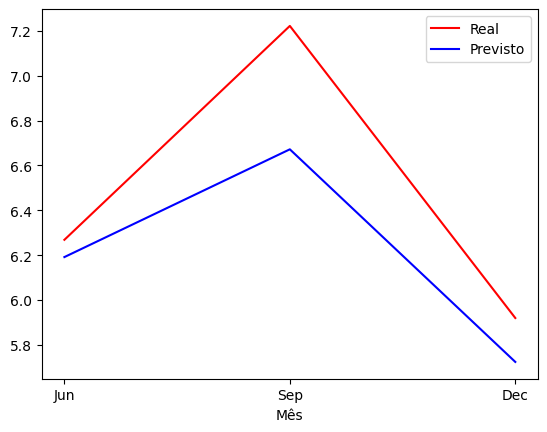

In [26]:
plt.plot(train_results['valor_real'], color='red', label = 'Real')
plt.plot(train_results['previsao'], color='blue', label = 'Previsto')
# Formatando o eixo x para mostrar apenas o mês
plt.xticks(ticks=train_results.index, labels=train_results.index.strftime('%b'))

plt.xlabel('Mês')
plt.legend()
plt.show()

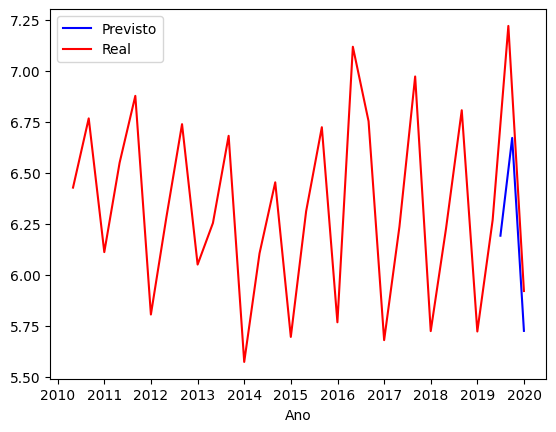

In [27]:
plt.plot(train_results['previsao'], color='blue', label = 'Previsto')
plt.plot(time_series, color='red', label = 'Real')

plt.xlabel('Ano')
plt.legend()
plt.show()

In [28]:
mse = mean_squared_error(train_results['valor_real'], train_results['previsao'])
mse

0.11548787

In [29]:
rmse = np.sqrt(mse)
rmse

0.33983508

In [30]:
mean_absolute_percentage_error(train_results['valor_real'], train_results['previsao'])

0.04048313

In [31]:
mean_absolute_error(train_results['valor_real'], train_results['previsao'])

0.27411428

In [32]:
tu = theil_u2(train_results['valor_real'], train_results['previsao'])
tu

0.6442417

In [33]:
train_data = time_series.values

# Normaliza os Dados
normalizer = MinMaxScaler(feature_range=(0,1))
train_data = normalizer.fit_transform(train_data)

# Cria os Arrays No Formato Certo
x = []
y = []
for i in range(0, len(train_data)):  # Mudança aqui para 3 quadrimestres
  x.append(train_data[i-3:i, 0])
  y.append(train_data[i,0])
x, y = np.array(x), np.array(y)
x = np.reshape(x, (x.shape[0], x.shape[1], 1))

# Converte os Dados Para Float
x = np.asarray(x).astype('float32')
y = np.asarray(y).astype('float32')

# Divisão dos dados em treino e teste
x_train, y_train = x[:24], y[:24]  # 24 quadrimestres para treinamento
x_test, y_test = x[24:], y[24:]    # O restante para teste

# Criação do Modelo de Rede Neural
dropout_val = 0.2
regressor = Sequential()
regressor.add(LSTM(units=800, return_sequences=True, input_shape=(x_train.shape[1],1)))
regressor.add(Dropout(dropout_val))

regressor.add(LSTM(units=300, return_sequences=True))
regressor.add(Dropout(dropout_val))

regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(dropout_val))

regressor.add(LSTM(units=200))
regressor.add(Dropout(dropout_val))

regressor.add(Dense(units=1, activation='linear'))

regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Treinamento do modelo
history = regressor.fit(x_train, y_train, batch_size=16, epochs=100)

y_test = y_test.reshape(-1, 1)
train_predictions = regressor.predict(x_test)
train_predictions = normalizer.inverse_transform(train_predictions)
y_test = normalizer.inverse_transform(y_test)

train_results = pd.DataFrame(zip(train_predictions, y_test), columns=['previsao', 'valor_real'])
train_results['previsao'] = train_results['previsao'].apply(lambda x: x[0])
train_results['valor_real'] = train_results['valor_real'].apply(lambda x: x[0])

start_date = "2017-01-01"
train_results['data'] = pd.date_range(start=start_date, periods=len(train_results), freq='Q')  # Frequência quadrimestral
train_results.set_index('data', inplace=True)

# Visualizando os resultados
plt.plot(train_results['valor_real'], color='red', label='Real')
plt.plot(train_results['previsao'], color='blue', label='Previsto')
plt.xticks(ticks=train_results.index, labels=train_results.index.strftime('%Q-%Y'))  # Exibe o quadrimestre e ano
plt.xlabel('Quadrimestre')
plt.legend()
plt.show()

plt.plot(train_results['previsao'], color='blue', label='Previsto')
plt.plot(time_series, color='red', label='Real')
plt.xlabel('Ano')
plt.legend()
plt.show()

# Calculando os erros
mse = mean_squared_error(train_results['valor_real'], train_results['previsao'])
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(train_results['valor_real'], train_results['previsao'])
mae = mean_absolute_error(train_results['valor_real'], train_results['previsao'])
tu = theil_u2(train_results['valor_real'], train_results['previsao'])


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (30,) + inhomogeneous part.

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.3139 - mean_squared_error: 0.3139
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2777 - mean_squared_error: 0.2777
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2276 - mean_squared_error: 0.2276
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1644 - mean_squared_error: 0.1644
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0791 - mean_squared_error: 0.0791
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1789 - mean_squared_error: 0.1789
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1001 - mean_squared_error: 0.1001
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0642 - mean_squared_error: 0.0642
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0792 - mean_squared_error: 0.0792
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1017 - mean_squared_error: 0.1017
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 

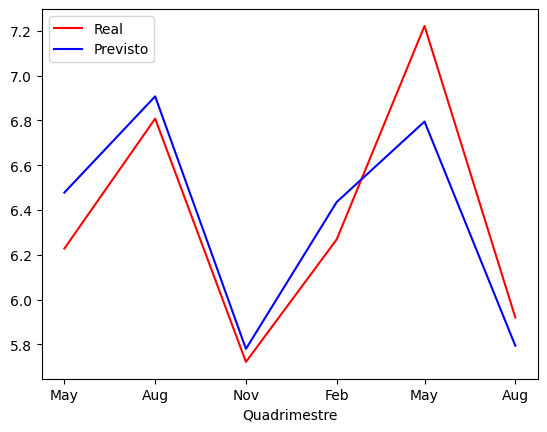

MSE: 0.050300729921445485
RMSE: 0.2242782421935875
MAPE: 0.028660138395623706
MAE: 0.18792146888244807
Teil U2: 0.8281214800612019


In [34]:
# Conexão com BigQuery
from google.cloud import bigquery
from google.oauth2 import service_account
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import keras_tuner as kt
import matplotlib.pyplot as plt
import math
import calendar
from sklearn.metrics import mean_squared_error
from sklearn.metrics import average_precision_score
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from matplotlib.pylab import rcParams
from scikeras.wrappers import KerasRegressor
from keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint, uniform
import keras_tuner
from keras.layers import LSTM, Dropout, Dense
from scipy.stats import randint, uniform
from sklearn.preprocessing import MinMaxScaler

# Realizar conexão com o GCP
credentials = service_account.Credentials.from_service_account_file("../keys/ml-na-saude-ed1fc3c1a83e.json")
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# Consulta SQL para buscar dados da taxa de YLL quadrimestral
consulta_sql = """
select
  a.quadrimestre,
  avg(a.taxa_yll) as taxa_media_yll
from (
with yll_quadrimestral as (
	select
		case
			when extract(month from y.dt_obito) between 1 and 4 then date(extract(year from y.dt_obito), 4, 30)
			when extract(month from y.dt_obito) between 5 and 8 then date(extract(year from y.dt_obito), 8, 31)
			when extract(month from y.dt_obito) between 9 and 12 then date(extract(year from y.dt_obito), 12, 31)
			end as quadrimestre,
		m.nm_municipio,
		p.populacao,
		sum(y.yll) as soma_yll
	from `ml-na-saude.yll_por_obito.yll` y
	join `ml-na-saude.yll_por_obito.populacao` p on y.cd_mun_res = p.cd_municipio and y.ano_obito = p.ano
	join `ml-na-saude.yll_por_obito.municipio` m on p.cd_municipio = m.cd_municipio
	where p.porte = 'Médio Porte'
    group by 1,2,3
)
select
	quadrimestre,
	nm_municipio,
  soma_yll,
  populacao,
  soma_yll / populacao * 1000 as taxa_yll
from yll_quadrimestral
group by 1,2,3,4
) a
group by 1
order by 1
"""

# Ignorar avisos e gerar dataframe
warnings.simplefilter("ignore")
df = client.query(consulta_sql).to_dataframe()

# Copiar dataframe para manipular dados
time_series = df.copy()

# Transformando o quadrimestre em data
time_series['quadrimestre'] = pd.to_datetime(time_series['quadrimestre'])

# Setando o quadrimestre como índice da tabela
time_series = time_series.set_index('quadrimestre')

# Divisão entre treinamento e teste com base na data usando o índice 'quadrimestre'
train_data = time_series[time_series.index <= '2016-12-31']
test_data = time_series[time_series.index > '2016-12-31']

# Agora, vamos extrair os dados para treino e teste (em formato numpy)
train_values = train_data['taxa_media_yll'].values
test_values = test_data['taxa_media_yll'].values

# Normalização dos dados
normalizer = MinMaxScaler(feature_range=(0, 1))
train_values_scaled = normalizer.fit_transform(train_values.reshape(-1, 1))
test_values_scaled = normalizer.transform(test_values.reshape(-1, 1))

# Preparando os dados para o LSTM (com 3 períodos passados como input)
def create_dataset(data, time_step=3):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

x_train, y_train = create_dataset(train_values_scaled)
x_test, y_test = create_dataset(test_values_scaled)

# Redimensionando os dados para a entrada do LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Criando o Modelo LSTM
dropout_val = 0.2
regressor = Sequential()
regressor.add(LSTM(units=800, return_sequences=True, input_shape=(x_train.shape[1], 1)))
regressor.add(Dropout(dropout_val))

regressor.add(LSTM(units=300, return_sequences=True))
regressor.add(Dropout(dropout_val))

regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(dropout_val))

regressor.add(LSTM(units=200))
regressor.add(Dropout(dropout_val))

regressor.add(Dense(units=1, activation='linear'))

regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Treinando o modelo com o conjunto de treinamento
history = regressor.fit(x_train, y_train, batch_size=16, epochs=100)

# Fazendo previsões
y_test = y_test.reshape(-1, 1)
train_predictions = regressor.predict(x_test)
train_predictions = normalizer.inverse_transform(train_predictions)
y_test = normalizer.inverse_transform(y_test)

# Organizando os resultados para visualização
train_results = pd.DataFrame(zip(train_predictions, y_test), columns=['previsao', 'valor_real'])
train_results['previsao'] = train_results['previsao'].apply(lambda x: x[0])
train_results['valor_real'] = train_results['valor_real'].apply(lambda x: x[0])

# Atualizando o dataframe de resultados com as datas quadrimestrais
train_results['data'] = pd.date_range(start='2010-04-30', periods=len(train_results), freq='3MS')
train_results.set_index('data', inplace=True)

# Exibindo os resultados
plt.plot(train_results['valor_real'], color='red', label='Real')
plt.plot(train_results['previsao'], color='blue', label='Previsto')
plt.xticks(ticks=train_results.index, labels=train_results.index.strftime('%b'))
plt.xlabel('Quadrimestre')
plt.legend()
plt.show()

# Cálculos de erros
mse = mean_squared_error(train_results['valor_real'], train_results['previsao'])
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(train_results['valor_real'], train_results['previsao'])
mae = mean_absolute_error(train_results['valor_real'], train_results['previsao'])

# Calculando o Theil's U2
def theil_u2(y_true, y_pred):
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    
    N = len(y_true)
    
    y_true_prev = y_true[:-1]
    y_true_next = y_true[1:]
    y_pred_prev = y_pred[:-1]
    y_pred_next = y_pred[1:]
    
    numerator = np.sqrt(np.mean(np.square((y_pred_next - y_pred_prev) / y_true_prev)))
    denominator = np.sqrt(np.mean(np.square((y_true_next - y_true_prev) / y_true_prev)))
    
    theilU2 = numerator / denominator

    return theilU2

tu = theil_u2(train_results['valor_real'], train_results['previsao'])

# Exibindo os erros
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'MAE: {mae}')
print(f'Teil U2: {tu}')


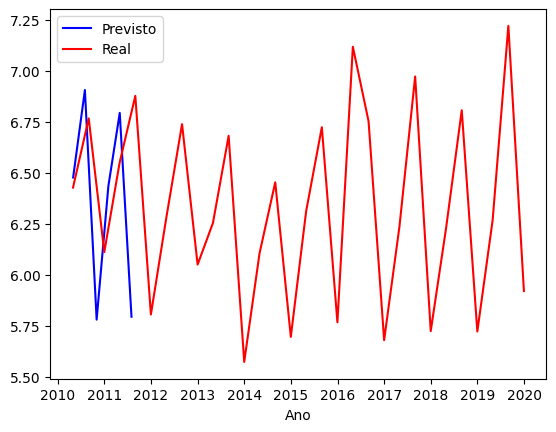

In [35]:
plt.plot(train_results['previsao'], color='blue', label = 'Previsto')
plt.plot(time_series, color='red', label = 'Real')


plt.xlabel('Ano')
plt.legend()
plt.show()

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2167 - val_loss: 0.2054
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1487 - val_loss: 0.1140
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0906 - val_loss: 0.1231
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1160 - val_loss: 0.1135
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0931 - val_loss: 0.1112
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0847 - val_loss: 0.1156
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0850 - val_loss: 0.1189
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0874 - val_loss: 0.1136
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0678 - val_loss: 0.1119
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0734 - val_loss: 0.1078
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0790 - val_loss: 0.1058
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0693 - val_lo

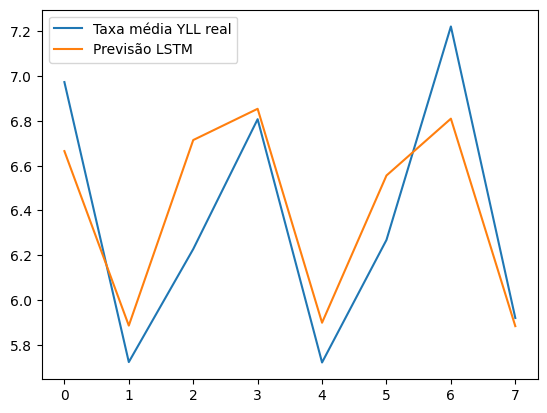

In [241]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Conexão com BigQuery
from google.cloud import bigquery
from google.oauth2 import service_account
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import keras_tuner as kt
import matplotlib.pyplot as plt
import math
import calendar
from sklearn.metrics import mean_squared_error
from sklearn.metrics import average_precision_score
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from matplotlib.pylab import rcParams
from scikeras.wrappers import KerasRegressor
from keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint, uniform
import keras_tuner
from keras.layers import LSTM, Dropout, Dense
from scipy.stats import randint, uniform
from sklearn.preprocessing import MinMaxScaler

# Realizar conexão com o GCP
credentials = service_account.Credentials.from_service_account_file("../keys/ml-na-saude-ed1fc3c1a83e.json")
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# Consulta SQL para buscar dados da taxa de YLL quadrimestral
consulta_sql = """
select
  a.quadrimestre,
  avg(a.taxa_yll) as taxa_media_yll
from (
with yll_quadrimestral as (
	select
		case
			when extract(month from y.dt_obito) between 1 and 4 then date(extract(year from y.dt_obito), 4, 30)
			when extract(month from y.dt_obito) between 5 and 8 then date(extract(year from y.dt_obito), 8, 31)
			when extract(month from y.dt_obito) between 9 and 12 then date(extract(year from y.dt_obito), 12, 31)
			end as quadrimestre,
		m.nm_municipio,
		p.populacao,
		sum(y.yll) as soma_yll
	from `ml-na-saude.yll_por_obito.yll` y
	join `ml-na-saude.yll_por_obito.populacao` p on y.cd_mun_res = p.cd_municipio and y.ano_obito = p.ano
	join `ml-na-saude.yll_por_obito.municipio` m on p.cd_municipio = m.cd_municipio
	where p.porte = 'Médio Porte'
    group by 1,2,3
)
select
	quadrimestre,
	nm_municipio,
  soma_yll,
  populacao,
  soma_yll / populacao * 1000 as taxa_yll
from yll_quadrimestral
group by 1,2,3,4
) a
group by 1
order by 1
"""

# Ignorar avisos e gerar dataframe
warnings.simplefilter("ignore")
df = client.query(consulta_sql).to_dataframe()

# Copiar dataframe para manipular dados
time_series = df.copy()

# 1. Carregar os dados
time_series_data = time_series['taxa_media_yll'].values

# 2. Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
time_series_data = scaler.fit_transform(time_series_data.reshape(-1, 1))

# 3. Preparar os dados para a LSTM
def create_sequences(data, seq_length=4):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Definir o tamanho da sequência de entrada
sequence_length = 4
X, y = create_sequences(time_series_data, sequence_length)

# 4. Dividir os dados em treino e teste
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 5. Construir o modelo LSTM
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dense(1)
])

# 6. Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# 7. Treinar o modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test), verbose=1)

# 8. Fazer previsões
predicted = model.predict(X_test)

# 9. Desnormalizar os dados para interpretação
predicted = scaler.inverse_transform(predicted)
y_test = scaler.inverse_transform(y_test)

# 10. Avaliar o modelo
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predicted)
print(f'Mean Squared Error: {mse}')

# Plotar resultados
import matplotlib.pyplot as plt

plt.plot(range(len(y_test)), y_test, label='Taxa média YLL real')
plt.plot(range(len(predicted)), predicted, label='Previsão LSTM')
plt.legend()
plt.show()


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.1978 - val_loss: 0.1461
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0870 - val_loss: 0.1311
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0989 - val_loss: 0.1195
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0919 - val_loss: 0.1313
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1005 - val_loss: 0.1467
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0815 - val_loss: 0.1419
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0780 - val_loss: 0.1249
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0945 - val_loss: 0.1163
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0873 - val_loss: 0.1156
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0927 - val_loss: 0.1156
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0845 - val_loss: 0.1196
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0918 - val_lo

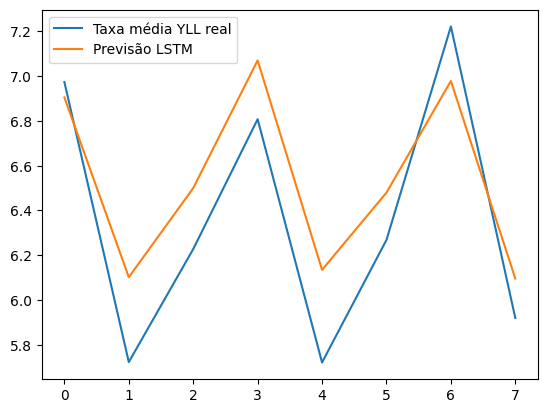

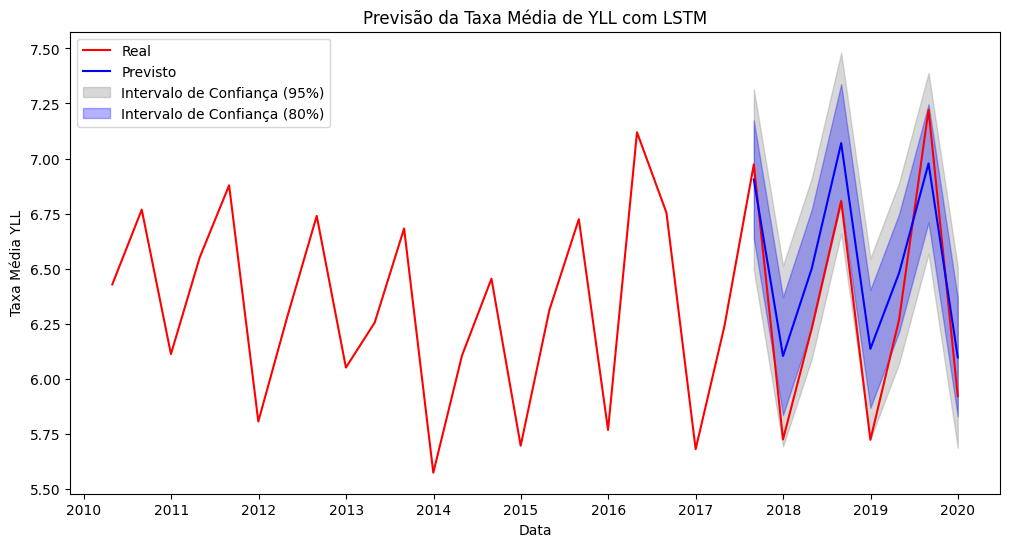

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense, Dropout

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Conexão com BigQuery
from google.cloud import bigquery
from google.oauth2 import service_account
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import keras_tuner as kt
import matplotlib.pyplot as plt
import math
import calendar
from sklearn.metrics import mean_squared_error
from sklearn.metrics import average_precision_score
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from matplotlib.pylab import rcParams
from scikeras.wrappers import KerasRegressor
from keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint, uniform
import keras_tuner
from keras.layers import LSTM, Dropout, Dense
from scipy.stats import randint, uniform
from sklearn.preprocessing import MinMaxScaler

# Realizar conexão com o GCP
credentials = service_account.Credentials.from_service_account_file("../keys/ml-na-saude-ed1fc3c1a83e.json")
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# Consulta SQL para buscar dados da taxa de YLL quadrimestral
consulta_sql = """
select
  a.quadrimestre,
  avg(a.taxa_yll) as taxa_media_yll
from (
with yll_quadrimestral as (
	select
		case
			when extract(month from y.dt_obito) between 1 and 4 then date(extract(year from y.dt_obito), 4, 30)
			when extract(month from y.dt_obito) between 5 and 8 then date(extract(year from y.dt_obito), 8, 31)
			when extract(month from y.dt_obito) between 9 and 12 then date(extract(year from y.dt_obito), 12, 31)
			end as quadrimestre,
		m.nm_municipio,
		p.populacao,
		sum(y.yll) as soma_yll
	from `ml-na-saude.yll_por_obito.yll` y
	join `ml-na-saude.yll_por_obito.populacao` p on y.cd_mun_res = p.cd_municipio and y.ano_obito = p.ano
	join `ml-na-saude.yll_por_obito.municipio` m on p.cd_municipio = m.cd_municipio
	where p.porte = 'Médio Porte'
    group by 1,2,3
)
select
	quadrimestre,
	nm_municipio,
  soma_yll,
  populacao,
  soma_yll / populacao * 1000 as taxa_yll
from yll_quadrimestral
group by 1,2,3,4
) a
group by 1
order by 1
"""

# Ignorar avisos e gerar dataframe
warnings.simplefilter("ignore")
df = client.query(consulta_sql).to_dataframe()

# Copiar dataframe para manipular dados
time_series = df.copy()

# 1. Carregar os dados e definir o índice de data
time_series['quadrimestre'] = pd.to_datetime(time_series['quadrimestre'])
time_series.set_index('quadrimestre', inplace=True)
time_series_data = time_series['taxa_media_yll'].values

# 2. Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
time_series_data = scaler.fit_transform(time_series_data.reshape(-1, 1))

# 3. Preparar os dados para a LSTM
def create_sequences(data, seq_length=4):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 4
X, y = create_sequences(time_series_data, sequence_length)

# 4. Dividir os dados em treino e teste (70/30)
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 5. Construir o modelo LSTM
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dense(1)
])

# 6. Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# 7. Treinar o modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test), verbose=1)

# 8. Fazer previsões
predicted = model.predict(X_test)

# 9. Desnormalizar as previsões e valores reais para comparação
predicted = scaler.inverse_transform(predicted)
y_test = scaler.inverse_transform(y_test)

# 10. Calcular intervalos de confiança (simples) usando desvio padrão das previsões
std_dev = np.std(predicted - y_test)
upper_bound_95 = predicted.flatten() + 1.96 * std_dev
lower_bound_95 = predicted.flatten() - 1.96 * std_dev
upper_bound_80 = predicted.flatten() + 1.28 * std_dev
lower_bound_80 = predicted.flatten() - 1.28 * std_dev

# 11. Calcular as métricas de erro
mse = mean_squared_error(y_test, predicted)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, predicted)
mae = mean_absolute_error(y_test, predicted)
tu = np.sum((predicted - y_test) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'MAE: {mae}')
print(f'TU: {tu}')

# Plotar resultados
import matplotlib.pyplot as plt

plt.plot(range(len(y_test)), y_test, label='Taxa média YLL real')
plt.plot(range(len(predicted)), predicted, label='Previsão LSTM')
plt.legend()
plt.show()

# 12. Plotar os resultados com intervalos de confiança
plt.figure(figsize=(12, 6))

# Dados reais completos
plt.plot(time_series.index, time_series['taxa_media_yll'], color='red', label='Real', marker='')

# Previsões
test_index = time_series.index[-len(y_test):]
plt.plot(test_index, predicted, color='blue', label='Previsto', marker='')

# Intervalo de confiança
plt.fill_between(test_index, lower_bound_95, upper_bound_95, color='gray', alpha=0.3, label='Intervalo de Confiança (95%)')
plt.fill_between(test_index, lower_bound_80, upper_bound_80, color='blue', alpha=0.3, label='Intervalo de Confiança (80%)')

# Labels e título
plt.title('Previsão da Taxa Média de YLL com LSTM')
plt.xlabel('Data')
plt.ylabel('Taxa Média YLL')
plt.legend()
plt.show()


In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from google.cloud import bigquery
from google.oauth2 import service_account
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Conexão com GCP (mantido igual)
credentials = service_account.Credentials.from_service_account_file("../keys/ml-na-saude-ed1fc3c1a83e.json")
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# Consulta SQL (mantida igual)
consulta_sql = """
select
    tx.mes,
    avg(tx.taxa_yll) as taxa_media_yll
from (
    with yll_mensal as (
        select
            date(extract(year from y.dt_obito), extract(month from y.dt_obito), 1) as mes,
            m.nm_municipio,
            p.populacao,
            sum(y.yll) as soma_yll
        from `ml-na-saude.yll_por_obito.yll` y
        join `ml-na-saude.yll_por_obito.populacao` p on y.cd_mun_res = p.cd_municipio and y.ano_obito = p.ano
        join `ml-na-saude.yll_por_obito.municipio` m on p.cd_municipio = m.cd_municipio
        where p.porte = 'Médio Porte'
        group by 1, 2, 3
    )
    select
        mes,
        nm_municipio,
        soma_yll,
        populacao,
        soma_yll / populacao * 1000 AS taxa_yll
    from yll_mensal
    group by 1, 2, 3, 4
) tx
group by 1
order by 1
"""

# Ignorar avisos e gerar dataframe
warnings.simplefilter("ignore")
df = client.query(consulta_sql).to_dataframe()

# Preparar dados com features sazonais
time_series = df.copy()
time_series['mes'] = pd.to_datetime(time_series['mes'])
time_series.set_index('mes', inplace=True)

# Adicionar features sazonais
time_series['month'] = time_series.index.month
time_series['year'] = time_series.index.year
time_series['quarter'] = time_series.index.quarter

# Normalizar dados
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_X = MinMaxScaler(feature_range=(0, 1))

# Preparar features
def create_features(df, target_col, sequence_length=6):
    features = []
    targets = []
    
    # Normalizar o target
    target_data = scaler_y.fit_transform(df[target_col].values.reshape(-1, 1))
    
    # Criar features para cada sequência
    for i in range(len(df) - sequence_length):
        # Dados históricos
        hist_data = target_data[i:i+sequence_length]
        
        # Features sazonais
        month = df.index[i+sequence_length].month / 12.0
        quarter = df.index[i+sequence_length].quarter / 4.0
        
        # Combinar todas as features
        sequence_features = np.column_stack((
            hist_data,
            np.full((sequence_length, 1), month),
            np.full((sequence_length, 1), quarter)
        ))
        
        features.append(sequence_features)
        targets.append(target_data[i+sequence_length])
    
    return np.array(features), np.array(targets)

# Preparar sequências
sequence_length = 6  # Reduzido para 6 meses
X, y = create_features(time_series, 'taxa_media_yll', sequence_length)

# Dividir dados
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Modelo LSTM simplificado
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, X_train.shape[2])),
    Dropout(0.1),
    Dense(25, activation='relu'),
    Dense(1)
])

# Compilar modelo
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Treinar modelo
history = model.fit(
    X_train, 
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# Fazer previsões
predicted = model.predict(X_test)

# Desnormalizar previsões
predicted = scaler_y.inverse_transform(predicted)
y_test = scaler_y.inverse_transform(y_test)

# Calcular métricas
mse = mean_squared_error(y_test, predicted)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, predicted)
mae = mean_absolute_error(y_test, predicted)
tu = np.sum((predicted - y_test) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)

print('\nMétricas de Avaliação:')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAPE: {mape:.4f}')
print(f'MAE: {mae:.4f}')
print(f'Theil U: {tu:.4f}')

# Visualizar resultados
plt.figure(figsize=(15, 7))

# Dados reais
test_dates = time_series.index[-len(y_test):]
plt.plot(time_series.index, time_series['taxa_media_yll'], 
         color='red', label='Dados Reais', alpha=0.7)

# Previsões
plt.plot(test_dates, predicted, 
         color='blue', label='Previsões', linestyle='--')

# Calcular e plotar intervalos de confiança
std_dev = np.std(predicted - y_test)
upper_bound = predicted.flatten() + 1.96 * std_dev
lower_bound = predicted.flatten() - 1.96 * std_dev

plt.fill_between(test_dates, 
                 lower_bound, 
                 upper_bound, 
                 color='blue', 
                 alpha=0.1, 
                 label='Intervalo de Confiança 95%')

plt.title('Previsão da Taxa Média de YLL Mensal')
plt.xlabel('Data')
plt.ylabel('Taxa Média YLL')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotar histórico de loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Histórico de Loss do Modelo')
plt.xlabel('Época')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

NameError: name 'EarlyStopping' is not defined


Treinando modelo lstm com sequence_length 4
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step

Treinando modelo gru com sequence_length 4
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step

Treinando modelo bidirectional com sequence_length 4
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step

Treinando modelo lstm com sequence_length 6
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step

Treinando modelo gru com sequence_length 6
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step

Treinando modelo bidirectional com sequence_length 6
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step

Treinando modelo lstm com sequence_length 8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step

Treinando modelo gru com sequence_length 8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step

Treinando modelo bidirectional com sequence_length 8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step

Métricas de Avaliação do Ensemble:
MSE: 0.0137
RMSE: 0.1172
MAPE: 0.0566
MAE: 0.0924
Theil U: 0.5536


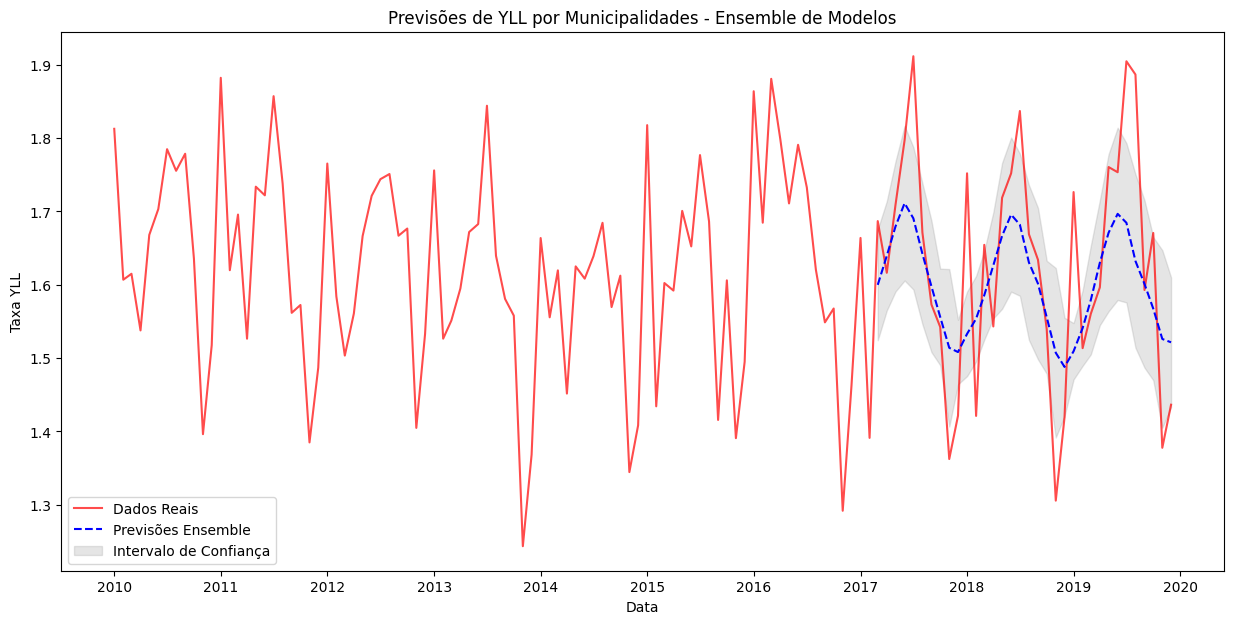

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, Bidirectional
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from google.cloud import bigquery
from google.oauth2 import service_account
import warnings
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns

# Conexão com GCP (mantido igual)
credentials = service_account.Credentials.from_service_account_file("../keys/ml-na-saude-ed1fc3c1a83e.json")
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# Consulta SQL (mantida igual)
consulta_sql = """
select
    tx.mes,
    avg(tx.taxa_yll) as taxa_media_yll
from (
    with yll_mensal as (
        select
            date(extract(year from y.dt_obito), extract(month from y.dt_obito), 1) as mes,
            m.nm_municipio,
            p.populacao,
            sum(y.yll) as soma_yll
        from `ml-na-saude.yll_por_obito.yll` y
        join `ml-na-saude.yll_por_obito.populacao` p on y.cd_mun_res = p.cd_municipio and y.ano_obito = p.ano
        join `ml-na-saude.yll_por_obito.municipio` m on p.cd_municipio = m.cd_municipio
        where p.porte = 'Médio Porte'
        group by 1, 2, 3
    )
    select
        mes,
        nm_municipio,
        soma_yll,
        populacao,
        soma_yll / populacao * 1000 AS taxa_yll
    from yll_mensal
    group by 1, 2, 3, 4
) tx
group by 1
order by 1
"""

# Ignorar avisos e gerar dataframe
warnings.simplefilter("ignore")
df = client.query(consulta_sql).to_dataframe()

def create_advanced_features(df):
    """Criar features avançadas para o modelo"""
    df_features = df.copy()
    df_features['mes'] = pd.to_datetime(df_features['mes'])
    df_features.set_index('mes', inplace=True)
    
    # Features temporais
    df_features['month'] = df_features.index.month
    df_features['quarter'] = df_features.index.quarter
    df_features['year'] = df_features.index.year
    df_features['day_of_year'] = df_features.index.dayofyear
    
    # Features cíclicas
    df_features['month_sin'] = np.sin(2 * np.pi * df_features['month']/12)
    df_features['month_cos'] = np.cos(2 * np.pi * df_features['month']/12)
    df_features['quarter_sin'] = np.sin(2 * np.pi * df_features['quarter']/4)
    df_features['quarter_cos'] = np.cos(2 * np.pi * df_features['quarter']/4)
    
    # Médias móveis
    df_features['ma3'] = df_features['taxa_media_yll'].rolling(window=3).mean()
    df_features['ma6'] = df_features['taxa_media_yll'].rolling(window=6).mean()
    df_features['ma12'] = df_features['taxa_media_yll'].rolling(window=12).mean()
    
    # Tendência
    df_features['trend'] = np.arange(len(df_features))
    
    # Lags específicos
    for i in [1, 2, 3, 6, 12]:
        df_features[f'lag_{i}'] = df_features['taxa_media_yll'].shift(i)
    
    # Preencher valores NaN
    df_features = df_features.fillna(method='bfill')
    
    return df_features

def create_sequences(data, seq_length):
    """Criar sequências para o modelo"""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

def create_model(input_shape, model_type='lstm'):
    """Criar um modelo específico baseado no tipo"""
    model = Sequential()
    
    if model_type == 'lstm':
        model.add(LSTM(64, activation='relu', input_shape=input_shape, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(32, activation='relu'))
    elif model_type == 'gru':
        model.add(GRU(64, activation='relu', input_shape=input_shape, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(GRU(32, activation='relu'))
    elif model_type == 'bidirectional':
        model.add(Bidirectional(LSTM(64, activation='relu'), input_shape=input_shape))
    
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='huber')
    return model

# Preparar dados
df_features = create_advanced_features(df)

# Separar features e target
target_col = 'taxa_media_yll'
feature_cols = [col for col in df_features.columns if col != target_col]

# Normalizar dados
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_X = StandardScaler()

y_normalized = scaler_y.fit_transform(df_features[target_col].values.reshape(-1, 1))
X_normalized = scaler_X.fit_transform(df_features[feature_cols])

# Criar sequências
sequence_lengths = [4, 6, 8]  # Testar diferentes comprimentos de sequência
model_types = ['lstm', 'gru', 'bidirectional']  # Diferentes tipos de modelo

# Preparar para ensemble
all_predictions = []
all_histories = []

for seq_length in sequence_lengths:
    X, y = create_sequences(X_normalized, seq_length)
    y = y_normalized[seq_length:]
    
    # Dividir dados
    train_size = int(len(X) * 0.7)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    for model_type in model_types:
        print(f"\nTreinando modelo {model_type} com sequence_length {seq_length}")
        
        # Criar e treinar modelo
        model = create_model((seq_length, X.shape[2]), model_type)
        
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        )
        
        history = model.fit(
            X_train, y_train,
            epochs=150,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=0
        )
        
        # Fazer previsões
        predictions = model.predict(X_test)
        all_predictions.append(predictions)
        all_histories.append(history.history)

# Verificar se todas as previsões têm o mesmo tamanho
min_length = min(len(pred) for pred in all_predictions)
all_predictions = [pred[:min_length] for pred in all_predictions]  # Ajustar para o tamanho mínimo

# Combinar previsões (média ponderada)
weights = np.ones(len(all_predictions)) / len(all_predictions)
ensemble_predictions = np.average(all_predictions, axis=0, weights=weights)

# Desnormalizar previsões
ensemble_predictions = scaler_y.inverse_transform(ensemble_predictions)
y_test_actual = scaler_y.inverse_transform(y_test)

# Calcular métricas
mse = mean_squared_error(y_test_actual, ensemble_predictions)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_actual, ensemble_predictions)
mae = mean_absolute_error(y_test_actual, ensemble_predictions)
tu = np.sum((ensemble_predictions - y_test_actual) ** 2) / np.sum((y_test_actual - np.mean(y_test_actual)) ** 2)

print('\nMétricas de Avaliação do Ensemble:')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAPE: {mape:.4f}')
print(f'MAE: {mae:.4f}')
print(f'Theil U: {tu:.4f}')

# Verificar se as previsões do ensemble estão unidimensionais
ensemble_predictions = ensemble_predictions.flatten()  # Garantir que as previsões sejam 1D
y_test_actual = y_test_actual.flatten()  # Garantir que os dados reais também sejam 1D

# Visualizar resultados
plt.figure(figsize=(15, 7))

# Dados reais
test_dates = df_features.index[-len(y_test_actual):]
plt.plot(df_features.index, df_features[target_col], 
         color='red', label='Dados Reais', alpha=0.7)

# Previsões do ensemble
plt.plot(test_dates, ensemble_predictions, 
         color='blue', label='Previsões Ensemble', linestyle='--')

# Intervalos de confiança
std_dev = np.std(all_predictions, axis=0).flatten()  # Garantir que a desvio padrão seja 1D
plt.fill_between(test_dates, ensemble_predictions - std_dev, ensemble_predictions + std_dev, 
                 color='gray', alpha=0.2, label='Intervalo de Confiança')

plt.xlabel('Data')
plt.ylabel('Taxa YLL')
plt.title('Previsões de YLL por Municipalidades - Ensemble de Modelos')
plt.legend()
plt.show()

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2647 - val_loss: 0.0636
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0432 - val_loss: 0.0612
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0528 - val_loss: 0.0587
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0525 - val_loss: 0.0566
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0431 - val_loss: 0.0565
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0399 - val_loss: 0.0577
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0411 - val_loss: 0.0560
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0398 - val_loss: 0.0558
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0479 - val_loss: 0.0553
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0426 - val_loss: 0.0546
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0467 - val_loss: 0.0546
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

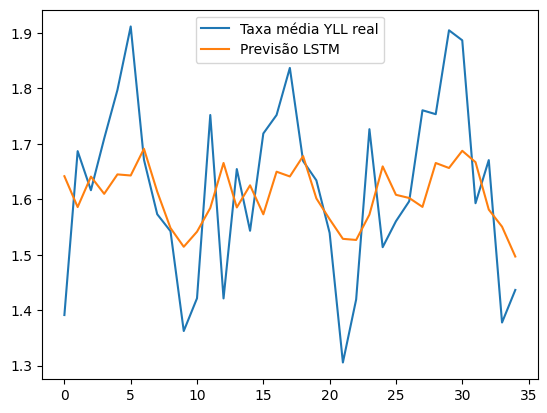

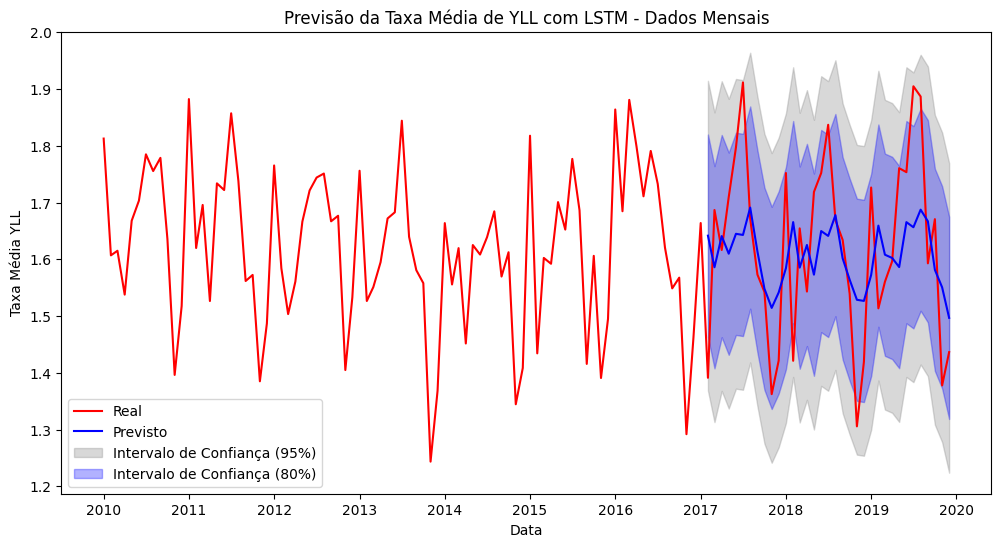

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Conexão com BigQuery
from google.cloud import bigquery
from google.oauth2 import service_account
import warnings
import pandas as pd
import numpy as np
import keras_tuner as kt
import seaborn as sns

# Realizar conexão com o GCP
credentials = service_account.Credentials.from_service_account_file("../keys/ml-na-saude-ed1fc3c1a83e.json")
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# Consulta SQL para buscar dados da taxa de YLL mensal
consulta_sql = """
select
  tx.mes,
  avg(tx.taxa_yll) as taxa_media_yll
from (
    with yll_mensal as (
        select
            date(extract(year from y.dt_obito), extract(month from y.dt_obito), 1) as mes,
            m.nm_municipio,
            p.populacao,
            sum(y.yll) as soma_yll
        from `ml-na-saude.yll_por_obito.yll` y
        join `ml-na-saude.yll_por_obito.populacao` p on y.cd_mun_res = p.cd_municipio and y.ano_obito = p.ano
        join `ml-na-saude.yll_por_obito.municipio` m on p.cd_municipio = m.cd_municipio
        where p.porte = 'Médio Porte'
        group by 1, 2, 3
    )
    select
        mes,
        nm_municipio,
        soma_yll,
        populacao,
        soma_yll / populacao * 1000 AS taxa_yll
    from yll_mensal
    group by 1, 2, 3, 4
) tx
group by 1
order by 1
"""

# Ignorar avisos e gerar dataframe
warnings.simplefilter("ignore")
df = client.query(consulta_sql).to_dataframe()

# Copiar dataframe para manipular dados
time_series = df.copy()

# 1. Carregar os dados e definir o índice de data
time_series['mes'] = pd.to_datetime(time_series['mes'])
time_series.set_index('mes', inplace=True)
time_series_data = time_series['taxa_media_yll'].values

# 2. Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
time_series_data = scaler.fit_transform(time_series_data.reshape(-1, 1))

# 3. Preparar os dados para a LSTM
def create_sequences(data, seq_length=4):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 4  # Como o agrupamento é mensal, mantemos o mesmo número de meses para a sequência
X, y = create_sequences(time_series_data, sequence_length)

# 4. Dividir os dados em treino e teste (70/30)
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 5. Construir o modelo LSTM
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dense(1)
])

# 6. Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# 7. Treinar o modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test), verbose=1)

# 8. Fazer previsões
predicted = model.predict(X_test)

# 9. Desnormalizar as previsões e valores reais para comparação
predicted = scaler.inverse_transform(predicted)
y_test = scaler.inverse_transform(y_test)

# 10. Calcular intervalos de confiança (simples) usando desvio padrão das previsões
std_dev = np.std(predicted - y_test)
upper_bound_95 = predicted.flatten() + 1.96 * std_dev
lower_bound_95 = predicted.flatten() - 1.96 * std_dev
upper_bound_80 = predicted.flatten() + 1.28 * std_dev
lower_bound_80 = predicted.flatten() - 1.28 * std_dev

# 11. Calcular as métricas de erro
mse = mean_squared_error(y_test, predicted)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, predicted)
mae = mean_absolute_error(y_test, predicted)
tu = np.sum((predicted - y_test) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'MAE: {mae}')
print(f'TU: {tu}')

# Plotar resultados
plt.plot(range(len(y_test)), y_test, label='Taxa média YLL real')
plt.plot(range(len(predicted)), predicted, label='Previsão LSTM')
plt.legend()
plt.show()

# 12. Plotar os resultados com intervalos de confiança
plt.figure(figsize=(12, 6))

# Dados reais completos
plt.plot(time_series.index, time_series['taxa_media_yll'], color='red', label='Real', marker='')

# Previsões
test_index = time_series.index[-len(y_test):]
plt.plot(test_index, predicted, color='blue', label='Previsto', marker='')

# Intervalo de confiança
plt.fill_between(test_index, lower_bound_95, upper_bound_95, color='gray', alpha=0.3, label='Intervalo de Confiança (95%)')
plt.fill_between(test_index, lower_bound_80, upper_bound_80, color='blue', alpha=0.3, label='Intervalo de Confiança (80%)')

# Labels e título
plt.title('Previsão da Taxa Média de YLL com LSTM - Dados Mensais')
plt.xlabel('Data')
plt.ylabel('Taxa Média YLL')
plt.legend()
plt.show()


Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.3492 - val_loss: 0.2891
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2341 - val_loss: 0.1544
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0908 - val_loss: 0.0857
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0780 - val_loss: 0.0690
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0432 - val_loss: 0.0695
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0609 - val_loss: 0.0668
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0422 - val_loss: 0.0674
Epoch 8/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0450 - val_loss: 0.0655
Epoch 9/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0516 - val_loss: 0.0684
Epoch 10/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0472 - val_loss: 0.0641
Epoch 11/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0442 - val_loss: 0.0629
Epoch 12/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

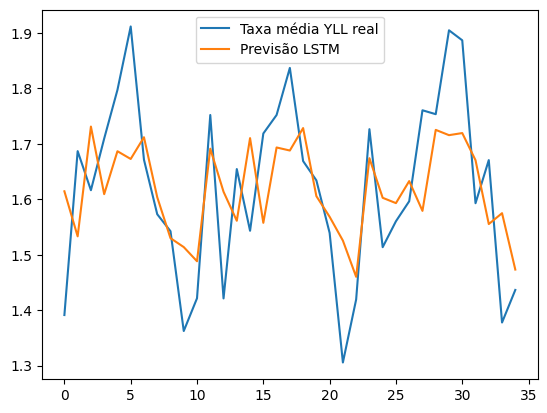

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Conexão com BigQuery
from google.cloud import bigquery
from google.oauth2 import service_account
import warnings
import pandas as pd
import numpy as np
import keras_tuner as kt
import seaborn as sns

# Realizar conexão com o GCP
credentials = service_account.Credentials.from_service_account_file("../keys/ml-na-saude-ed1fc3c1a83e.json")
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# Consulta SQL para buscar dados da taxa de YLL mensal
consulta_sql = """
select
  tx.mes,
  avg(tx.taxa_yll) as taxa_media_yll
from (
    with yll_mensal as (
        select
            date(extract(year from y.dt_obito), extract(month from y.dt_obito), 1) as mes,
            m.nm_municipio,
            p.populacao,
            sum(y.yll) as soma_yll
        from `ml-na-saude.yll_por_obito.yll` y
        join `ml-na-saude.yll_por_obito.populacao` p on y.cd_mun_res = p.cd_municipio and y.ano_obito = p.ano
        join `ml-na-saude.yll_por_obito.municipio` m on p.cd_municipio = m.cd_municipio
        where p.porte = 'Médio Porte'
        group by 1, 2, 3
    )
    select
        mes,
        nm_municipio,
        soma_yll,
        populacao,
        soma_yll / populacao * 1000 AS taxa_yll
    from yll_mensal
    group by 1, 2, 3, 4
) tx
group by 1
order by 1
"""

# Ignorar avisos e gerar dataframe
warnings.simplefilter("ignore")
df = client.query(consulta_sql).to_dataframe()

# Copiar dataframe para manipular dados
time_series = df.copy()

from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt

# 1. Carregar os dados e definir o índice de data
time_series['mes'] = pd.to_datetime(time_series['mes'])
time_series.set_index('mes', inplace=True)
time_series_data = time_series['taxa_media_yll'].values

# 2. Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
time_series_data = scaler.fit_transform(time_series_data.reshape(-1, 1))

# 3. Preparar os dados para a LSTM
def create_sequences(data, seq_length=4):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 4  # 4 meses como sequência
X, y = create_sequences(time_series_data, sequence_length)

# 4. Dividir os dados em treino e teste (70/30)
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 5. Construir o modelo LSTM
model = Sequential([
    LSTM(100, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),
    Dropout(0.2),  # Adicionar dropout para regularização
    LSTM(50, activation='relu'),
    Dense(1)
])

# 6. Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 7. Treinar o modelo
history = model.fit(X_train, y_train, epochs=200, batch_size=8, validation_data=(X_test, y_test), verbose=1)

# 8. Fazer previsões
predicted = model.predict(X_test)

# 9. Desnormalizar as previsões e valores reais para comparação
predicted = scaler.inverse_transform(predicted)
y_test = scaler.inverse_transform(y_test)

# 10. Calcular as métricas de erro
mse = mean_squared_error(y_test, predicted)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, predicted)
mae = mean_absolute_error(y_test, predicted)
tu = np.sum((predicted - y_test) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'MAE: {mae}')
print(f'TU: {tu}')

# Plotar resultados
plt.plot(range(len(y_test)), y_test, label='Taxa média YLL real')
plt.plot(range(len(predicted)), predicted, label='Previsão LSTM')
plt.legend()
plt.show()


Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.3243 - val_loss: 0.2589
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2002 - val_loss: 0.1097
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0677 - val_loss: 0.0942
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0556 - val_loss: 0.0698
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0585 - val_loss: 0.0750
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0536 - val_loss: 0.0691
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0569 - val_loss: 0.0678
Epoch 8/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0485 - val_loss: 0.0660
Epoch 9/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0516 - val_loss: 0.0667
Epoch 10/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0611 - val_loss: 0.0648
Epoch 11/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0432 - val_loss: 0.0644
Epoch 12/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

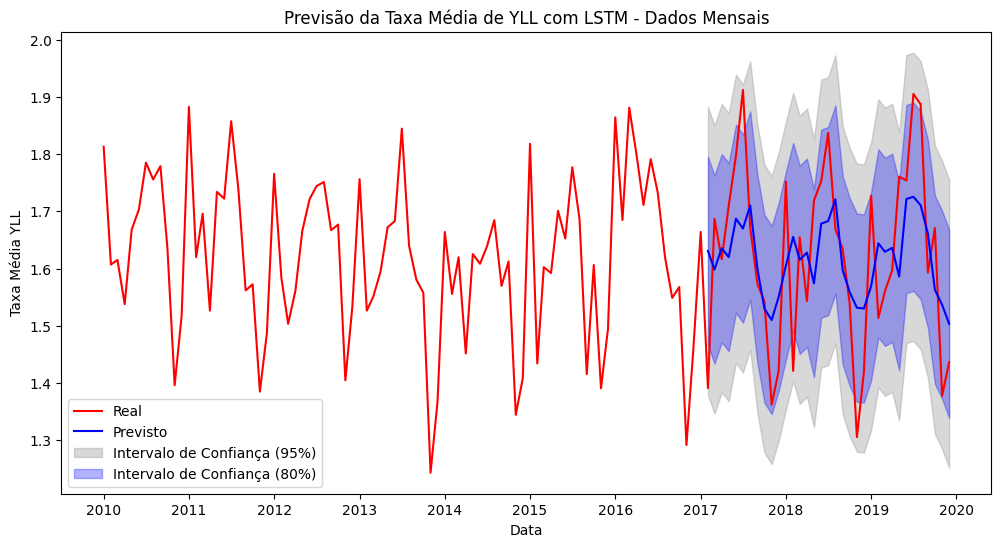

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Conexão com BigQuery
from google.cloud import bigquery
from google.oauth2 import service_account
import warnings
import pandas as pd
import numpy as np
import keras_tuner as kt
import seaborn as sns

# Realizar conexão com o GCP
credentials = service_account.Credentials.from_service_account_file("../keys/ml-na-saude-ed1fc3c1a83e.json")
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# Consulta SQL para buscar dados da taxa de YLL mensal
consulta_sql = """
select
  tx.mes,
  avg(tx.taxa_yll) as taxa_media_yll
from (
    with yll_mensal as (
        select
            date(extract(year from y.dt_obito), extract(month from y.dt_obito), 1) as mes,
            m.nm_municipio,
            p.populacao,
            sum(y.yll) as soma_yll
        from `ml-na-saude.yll_por_obito.yll` y
        join `ml-na-saude.yll_por_obito.populacao` p on y.cd_mun_res = p.cd_municipio and y.ano_obito = p.ano
        join `ml-na-saude.yll_por_obito.municipio` m on p.cd_municipio = m.cd_municipio
        where p.porte = 'Médio Porte'
        group by 1, 2, 3
    )
    select
        mes,
        nm_municipio,
        soma_yll,
        populacao,
        soma_yll / populacao * 1000 AS taxa_yll
    from yll_mensal
    group by 1, 2, 3, 4
) tx
group by 1
order by 1
"""

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import warnings

# 1. Ignorar avisos e gerar dataframe
warnings.simplefilter("ignore")
df = client.query(consulta_sql).to_dataframe()

# Copiar dataframe para manipular dados
time_series = df.copy()

# 2. Carregar os dados e definir o índice de data
time_series['mes'] = pd.to_datetime(time_series['mes'])
time_series.set_index('mes', inplace=True)
time_series_data = time_series['taxa_media_yll'].values

# 3. Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
time_series_data = scaler.fit_transform(time_series_data.reshape(-1, 1))

# 4. Preparar os dados para a LSTM
def create_sequences(data, seq_length=4):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 4  # 4 meses como sequência
X, y = create_sequences(time_series_data, sequence_length)

# 5. Dividir os dados em treino e teste (70/30)
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 6. Construir o modelo LSTM
model = Sequential([
    LSTM(100, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),
    Dropout(0.2),  # Adicionar dropout para regularização
    LSTM(50, activation='relu'),
    Dense(1)
])

# 7. Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 8. Treinar o modelo
history = model.fit(X_train, y_train, epochs=200, batch_size=8, validation_data=(X_test, y_test), verbose=1)

# 9. Fazer previsões
predicted = model.predict(X_test)

# 10. Desnormalizar as previsões e valores reais para comparação
predicted = scaler.inverse_transform(predicted)
y_test = scaler.inverse_transform(y_test)

# 11. Calcular as métricas de erro
mse = mean_squared_error(y_test, predicted)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, predicted)
mae = mean_absolute_error(y_test, predicted)
tu = np.sum((predicted - y_test) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'MAE: {mae}')
print(f'TU: {tu}')

# 12. Plotar os resultados com intervalos de confiança
plt.figure(figsize=(12, 6))

# Dados reais completos
plt.plot(time_series.index, time_series['taxa_media_yll'], color='red', label='Real', marker='')

# Previsões
test_index = time_series.index[-len(y_test):]
plt.plot(test_index, predicted.flatten(), color='blue', label='Previsto', marker='')

# Calcular o erro residual (diferença entre valores reais e previstos)
residuals = y_test - predicted
std_error = np.std(residuals)

# Definir os intervalos de confiança (95% e 80%)
confidence_interval_95 = 1.96 * std_error
confidence_interval_80 = 1.28 * std_error

# Intervalo de confiança (95%)
upper_bound_95 = predicted.flatten() + confidence_interval_95
lower_bound_95 = predicted.flatten() - confidence_interval_95

# Intervalo de confiança (80%)
upper_bound_80 = predicted.flatten() + confidence_interval_80
lower_bound_80 = predicted.flatten() - confidence_interval_80

# Plotar intervalo de confiança (95%)
plt.fill_between(test_index, lower_bound_95, upper_bound_95, color='gray', alpha=0.3, label='Intervalo de Confiança (95%)')

# Plotar intervalo de confiança (80%)
plt.fill_between(test_index, lower_bound_80, upper_bound_80, color='blue', alpha=0.3, label='Intervalo de Confiança (80%)')

# Labels e título
plt.title('Previsão da Taxa Média de YLL com LSTM - Dados Mensais')
plt.xlabel('Data')
plt.ylabel('Taxa Média YLL')
plt.legend()
plt.show()
